* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite 
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

In [8]:
# Cofactor lists
nadphs = ['nadph_c'] #, 'nadph_m', 'nadph_x']
nadhs = ['nadh_c']#, 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c'] #, 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1]


In [3]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1]
    growth_rates = [0.03396, 0.082468, 0.123068, 0.17302, 0.233464]
    
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective =  "ATPM"# 
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.reactions.BIOMASS_RT.bounds = growth_rates[i], growth_rates[i]

    solution = model.optimize('minimize') # 
    
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])

    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])
    

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [12]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, **fig_kw):
    threshold = 0.05# threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective = "ATPM" 
    solution = model.optimize('minimize')   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure(**fig_kw)
           
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.title(title)

    
    return pie_chart, fig

In [5]:
# import pickle

# with open("../cofactor_comparison/IFO0880_jsb_NGAM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)


In [6]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate
nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.5409558357599994, SUM consumed: -0.5409558357599961
SUM produced: 3.7188961495839736, SUM consumed: -3.718896149583837


,flux,reaction,percent
HSDy,2.934494,HSDy,0.789077
GND,0.302394,GND,0.081313
G6PDH2r,0.302394,G6PDH2r,0.081313
PYDXOR,0.164883,PYDXOR,0.044336
PPND2,0.014732,PPND2,0.003961
DPR,-0.000180,DPR,0.000048
KYN3OX,-0.000393,KYN3OX,0.000106
DHFR,-0.001500,DHFR,0.000403
FAS170COA_L,-0.013950,FAS170COA_L,0.003751
TRDR,-0.026442,TRDR,0.007110


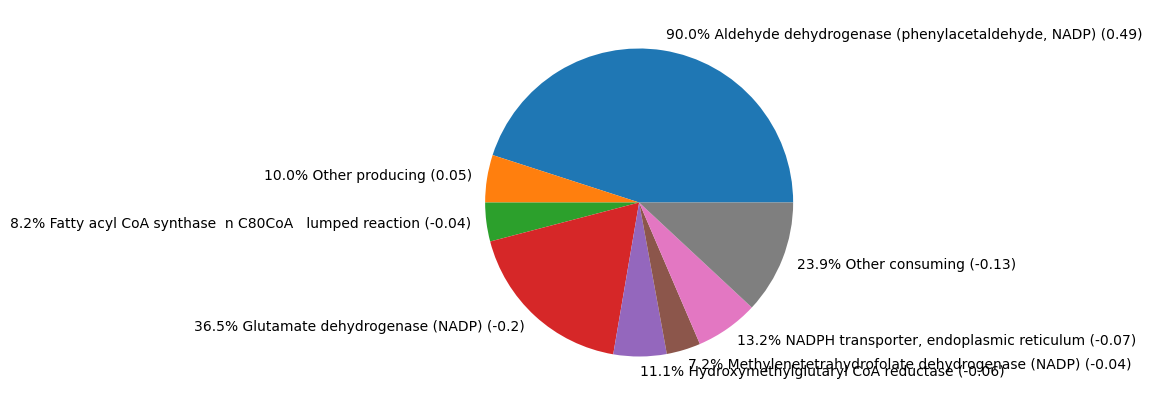

In [21]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, figsize=(13,5))
producing_nadph_fluxes_lowest_GR_pie_chart

plt.show()
fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_nm_NADPH.png")


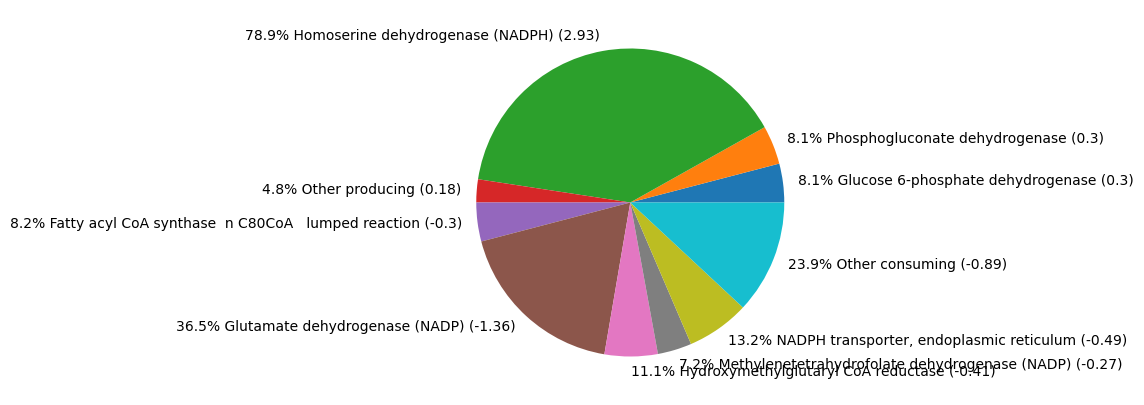

In [22]:
# Make a pie plot for napdh
# threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, figsize=(13,5))
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_nm_NADPH_max.png")


In [ ]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 1)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

SUM produced: 1.636794292987, SUM consumed: -1.6367942929872639
SUM produced: 4.504839603460492, SUM consumed: -4.5048396034539655


,flux,reaction,percent
GAPD,4.345425,GAPD,0.964613
IPMD,0.074756,IPMD,0.016595
SACCD2,0.040234,SACCD2,0.008931
HISTD,0.029211,HISTD,0.006484
IMPD,0.014122,IMPD,0.003135
GCALDD,0.000911,GCALDD,0.000202
BAMPPALDOX,0.000180,BAMPPALDOX,0.000040
DROPPRx,-0.000406,DROPPRx,0.000090
G3PD1ir,-0.020288,G3PD1ir,0.004504
MTHFR2,-0.028063,MTHFR2,0.006229


([<matplotlib.patches.Wedge at 0x28b77d97aa0>,
 [Text(0.05941554164417762, 1.0983941885366697, '96.6% Glyceraldehyde-3-phosphate dehydrogenase (1.58)'),
  Text(-1.0983941881889894, 0.059415548071620486, '3.4% Other producing (0.06)'),
  Text(-0.5583030285460021, -0.9477856974634942, '66.1% Alcohol dehydrogenase (ethanol) (-1.08)'),
  Text(0.5661552878253473, -0.9431162123871046, '2.2% Homoserine dehydrogenase  NADH   irreversible (-0.04)'),
  Text(0.9474066666691413, -0.558945979456751, '29.5% malate dehydrogenase (-0.48)'),
  Text(1.0993186759286826, -0.03870980178725416, '2.2% Other consuming (-0.04)')])

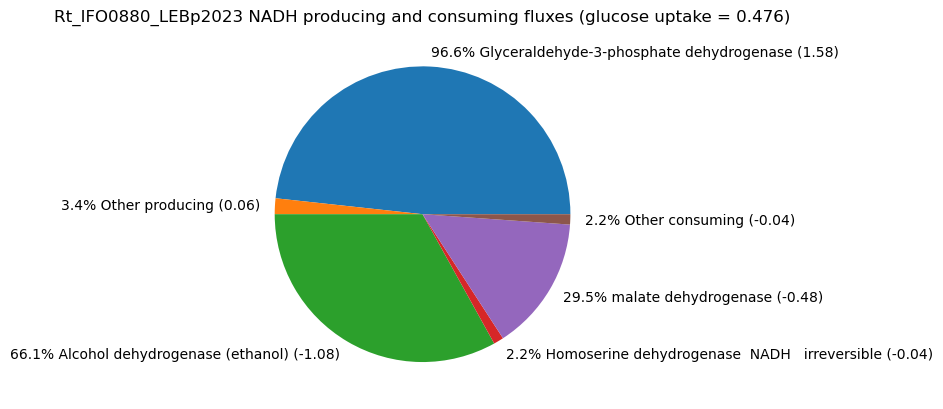

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x28b77df7e60>,
 [Text(0.06111344612135098, 1.0983010273614302, '96.5% Glyceraldehyde-3-phosphate dehydrogenase (4.35)'),
  Text(-1.098301029149509, 0.061113413986862514, '3.5% Other producing (0.16)'),
  Text(-0.5726707459737026, -0.9391742206353, '65.1% Aldehyde dehydrogenase (phenylacetaldehyde, NAD) (-2.93)'),
  Text(0.5381209390475677, -0.9593882712221179, '2.3% Homoserine dehydrogenase  NADH   irreversible (-0.1)'),
  Text(0.9387743285625169, -0.5733260503692431, '30.3% malate dehydrogenase (-1.36)'),
  Text(1.0992791467672325, -0.039816547850177554, '2.3% Other consuming (-0.1)')])

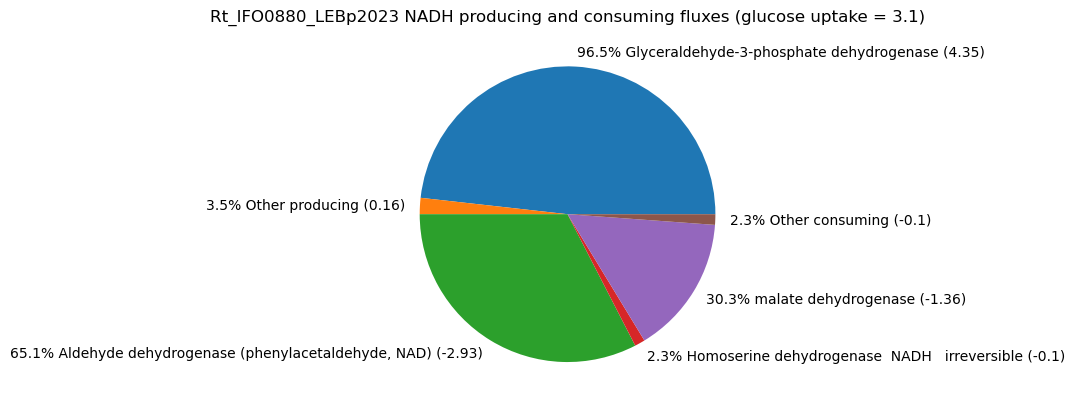

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart

In [ ]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

SUM produced: 7.898251940560618, SUM consumed: -7.898251940576365
SUM produced: 46.714707745901464, SUM consumed: -46.71470774589459


,flux,reaction,percent
ATPtm,38.109663,ATPtm,0.815796
PGK,4.345425,PGK,0.093020
PYK,4.258030,PYK,0.091150
URIDK2r,0.001589,URIDK2r,0.000034
FMNAT,-0.000175,FMNAT,0.000004
...,...,...,...
ACITL,-1.253723,ACITL,0.026838
ADK1,-1.495730,ADK1,0.032018
PFK,-2.140033,PFK,0.045811
HEX1,-3.100000,HEX1,0.066360


([<matplotlib.patches.Wedge at 0x28b76a26b40>,
 [Text(0.29644503677472356, 1.0593018173172521, '82.6% ADP/ATP transporter, mitochondrial (6.53)'),
  Text(-0.940245052223079, 0.5709108877662253, '0.0% Other producing (0.0)'),
  Text(-1.009720707978656, 0.43642191956761484, '8.8% Phosphoglycerate kinase (0.69)'),
  Text(-1.0899696480997445, 0.14820987221274962, '8.6% Pyruvate kinase (0.68)'),
  Text(-1.09927657084316, -0.03988760202498361, '2.3% ATP-Citrate lyase (-0.18)'),
  Text(-1.0926317997706774, -0.12710527184145617, '2.8% Adenylate kinase (-0.22)'),
  Text(-1.0123985463417398, -0.43017343405321107, '15.5% ATP maintenance requirement (-1.22)'),
  Text(0.018867346651173306, -1.0998381804749027, '60.1% Biomass (-4.74)'),
  Text(0.9570351757505785, -0.542294820532208, '6.0% Hexokinase (D-glucose:ATP) (-0.48)'),
  Text(1.0573672026084426, -0.3032731423123335, '9.0% Other consuming (-0.71)'),
  Text(1.0973908804808208, -0.07571826356652096, '4.4% Phosphofructokinase (-0.35)')])

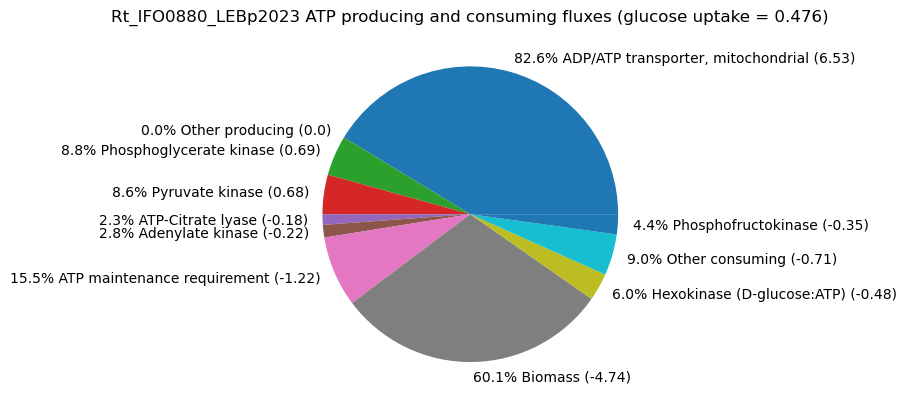

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x28b03f49c40>,
 [Text(0.3138593056933416, 1.0542733688326258, '81.6% ADP/ATP transporter, mitochondrial (38.11)'),
  Text(-0.9209273091894827, 0.6015753412408282, '0.0% Other producing (0.0)'),
  Text(-0.9987260421200247, 0.4610274317123339, '9.3% Phosphoglycerate kinase (4.35)'),
  Text(-1.088744363814529, 0.15695767028755378, '9.1% Pyruvate kinase (4.26)'),
  Text(-1.099022682359885, -0.046358857389755724, '2.7% ATP-Citrate lyase (-1.25)'),
  Text(-1.0900494004896204, -0.14762216802438416, '3.2% Adenylate kinase (-1.5)'),
  Text(-1.0720439628976803, -0.24641781919057174, '2.6% ATP maintenance requirement (-1.22)'),
  Text(-0.2263291833930271, -1.0764641660290628, '69.8% Biomass (-32.61)'),
  Text(0.921796913916464, -0.6002419924447832, '6.6% Hexokinase (D-glucose:ATP) (-3.1)'),
  Text(1.0480901583078617, -0.3339266686837119, '10.5% Other consuming (-4.89)'),
  Text(1.0971532592122213, -0.07908682443998132, '4.6% Phosphofructokinase (-2.14)')])

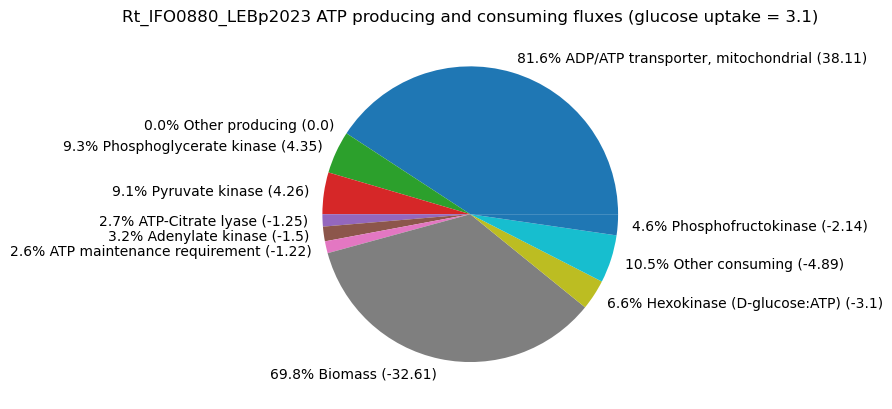

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\Rt_IFO0880_jsb_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
